## Part 4 – Design Challenge (20 points)

In [1]:
import random
from collections import defaultdict, Counter

class AveragedPerceptron:
    def __init__(self):
        self.weights = defaultdict(lambda: defaultdict(float))
        self.totals = defaultdict(float)
        self.timestamps = defaultdict(int)
        self.i = 0  # total updates

    def predict(self, features):
        scores = defaultdict(float)
        for feat, value in features.items():
            if value == 0 or feat not in self.weights:
                continue
            for label, weight in self.weights[feat].items():
                scores[label] += value * weight
        return max(scores, key=scores.get) if scores else 'O'

    def update(self, truth, guess, features):
        def upd_feat(feat, label, value):
            param = (feat, label)
            self.totals[param] += (self.i - self.timestamps[param]) * self.weights[feat][label]
            self.timestamps[param] = self.i
            self.weights[feat][label] += value

        self.i += 1
        if truth == guess:
            return
        for feat in features:
            upd_feat(feat, truth, 1.0)
            upd_feat(feat, guess, -1.0)

    def average_weights(self):
        for feat, weights in self.weights.items():
            for label in weights:
                param = (feat, label)
                total = self.totals[param] + (self.i - self.timestamps[param]) * weights[label]
                averaged = total / self.i
                if averaged:
                    self.weights[feat][label] = averaged
                else:
                    del self.weights[feat][label]


In [2]:
def extract_features(sentence, index):
    word = sentence[index]
    features = {
        'bias': 1.0,
        'word.lower=' + word.lower(): 1.0,
        'word[-3:]=' + word[-3:]: 1.0,
        'word[-2:]=' + word[-2:]: 1.0,
        'word.isupper=' + str(word.isupper()): 1.0,
        'word.istitle=' + str(word.istitle()): 1.0,
        'word.isdigit=' + str(word.isdigit()): 1.0,
    }
    if index > 0:
        prev = sentence[index - 1]
        features.update({
            '-1:word.lower=' + prev.lower(): 1.0,
            '-1:word.istitle=' + str(prev.istitle()): 1.0,
        })
    else:
        features['BOS'] = 1.0  # Beginning of sentence

    if index < len(sentence) - 1:
        next = sentence[index + 1]
        features.update({
            '+1:word.lower=' + next.lower(): 1.0,
            '+1:word.istitle=' + str(next.istitle()): 1.0,
        })
    else:
        features['EOS'] = 1.0  # End of sentence

    return features


In [3]:
def train_perceptron(dataset, epochs=5):
    model = AveragedPerceptron()
    for _ in range(epochs):
        random.shuffle(dataset)
        for sentence, tags in dataset:
            for i in range(len(sentence)):
                features = extract_features(sentence, i)
                pred = model.predict(features)
                model.update(tags[i], pred, features)
    model.average_weights()
    return model


In [4]:
def read_data(file_path):
    sentences, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        sent, labs = [], []
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    labels.append(labs)
                    sent, labs = [], []
                continue
            parts = line.split()
            if len(parts) == 2:
                token, label = parts
            else:
                token, label = parts[0], 'O'  # fallback if label is missing
            sent.append(token)
            labs.append(label)
        if sent:
            sentences.append(sent)
            labels.append(labs)
    return list(zip(sentences, labels))


In [5]:
def read_unlabeled_data(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sent = []
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    sent = []
                continue
            sent.append(line)
        if sent:
            sentences.append(sent)
    return sentences


In [6]:
train_file = "EN/train"
dev_in_file = "EN/dev.in"
gold_file = "EN/dev.out"

train_data = read_data(train_file)

# Load dev gold tags
dev_gold_data = read_data("EN/dev.out")
dev_data = [tokens for tokens, tags in dev_gold_data]
gold_dev_tags = [tags for tokens, tags in dev_gold_data]


model = train_perceptron(train_data, epochs=20)



In [8]:
dev_sentences = read_unlabeled_data(dev_in_file)

# model, train_f1s, dev_f1s = train_perceptron(train_data, dev_sentences, gold_dev_tags, epochs=30)

In [9]:

with open("EN/dev.p4.out", 'w', encoding='utf-8') as out_f:
    for sent in dev_sentences:
        for i in range(len(sent)):
            feats = extract_features(sent, i)
            pred = model.predict(feats)
            out_f.write(f"{sent[i]} {pred}\n")
        out_f.write("\n")


In [10]:
import datetime

with open("eval_log.txt", "a") as f:
    f.write(f"\n----- Run at {datetime.datetime.now()} -----\n")

!python EvalScript/evalResult.py EN/dev.out EN/dev.p4.out >> eval_log.txt


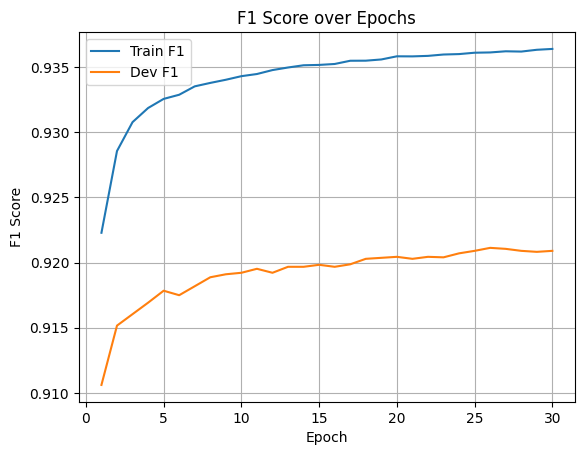

In [ ]:

# import matplotlib.pyplot as plt

# plt.plot(range(1, 31), train_f1s, label="Train F1")
# plt.plot(range(1, 31), dev_f1s, label="Dev F1")
# plt.xlabel("Epoch")
# plt.ylabel("F1 Score")
# plt.title("F1 Score over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# from sklearn.metrics import f1_score

# def train_perceptron(train_data, dev_data, gold_dev_tags, epochs=5):
#     model = AveragedPerceptron()
#     train_f1_scores = []
#     dev_f1_scores = []

#     for epoch in range(epochs):
#         print(f"Epoch {epoch + 1}/{epochs}")

#         # Training phase
#         for sentence, tags in train_data:
#             for i in range(len(sentence)):
#                 features = extract_features(sentence, i)
#                 pred = model.predict(features)
#                 model.update(tags[i], pred, features)
#         model.average_weights()

#         # --- F1 on train ---
#         train_preds = []
#         train_gold = []
#         for sentence, tags in train_data:
#             for i in range(len(sentence)):
#                 pred = model.predict(extract_features(sentence, i))
#                 train_preds.append(pred)
#                 train_gold.append(tags[i])
#         train_f1 = f1_score(train_gold, train_preds, average='micro', labels=list(set(train_gold)))
#         train_f1_scores.append(train_f1)

#         # --- F1 on dev ---
#         dev_preds = []
#         dev_gold = []
#         for sentence, tags in zip(dev_data, gold_dev_tags):
#             for i in range(len(sentence)):
#                 pred = model.predict(extract_features(sentence, i))
#                 dev_preds.append(pred)
#                 dev_gold.append(tags[i])
#         dev_f1 = f1_score(dev_gold, dev_preds, average='micro', labels=list(set(dev_gold)))
#         dev_f1_scores.append(dev_f1)

#         print(f"Train F1: {train_f1:.4f} | Dev F1: {dev_f1:.4f}")

#     return model, train_f1_scores, dev_f1_scores
